In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy
import random
warnings.filterwarnings("ignore")

2024-07-04 15:33:10.621578: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 15:33:10.624053: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 15:33:10.632531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 15:33:10.649164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 15:33:10.649191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 15:33:10.660000: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'NW_risk'

In [5]:
nr_common_PCs = 25
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 25
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [6]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

# Create phenotype only SNP dependent

# Effect based on AF

In [7]:
def multi(arr, effectsize):
    return [1 * (num + 0.001) * effectsize for num in arr]

def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [8]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in common.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in common.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_common = pd.DataFrame(data)
beta_common['maf'] = "common"

numbers_af = [float(col.split('_AF_')[1]) for col in rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_rare = pd.DataFrame(data)
beta_rare['maf'] = "rare"

numbers_af = [float(col.split('_AF_')[1]) for col in very_rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in very_rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
beta_very_rare = pd.DataFrame(data)
beta_very_rare['maf'] = "very rare"

betas = pd.concat([beta_common, beta_rare, beta_very_rare], ignore_index=True)

In [9]:
# Monogenic phenotype

In [10]:
all_snps = list(complete.columns)

In [11]:
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

In [12]:
int(np.round(len(all_snps)*0.001))

1

In [13]:
# Polygenic phenotype
proportion_poly = 0.01
poly_friends_quantity = int(np.round(len(all_snps)*proportion_poly))
phenos_poly = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    temp = complete[snp] * beta_value
    poly_snps = random.sample(all_snps, poly_friends_quantity)
    for poly_snp in poly_snps:
        beta_expected = betas.loc[betas['snp'] == poly_snp.split("_")[0], 'Beta'].values[0]
        temp += complete[snp]*(beta_expected/10)
    phenos_poly.append(temp)
# Converting phenos_mono list of series to DataFrame directly
phenos_poly = pd.concat(phenos_poly, axis=1)
phenos_poly.columns = complete.columns

# Monogenic

In [14]:
phenos_mono = phenos_poly

In [15]:
phenos_mono

snps,C0_AF_0.296425,C1_AF_0.21885,C2_AF_0.21275,C3_AF_0.2368,C4_AF_0.217525,C5_AF_0.20005,C6_AF_0.26035,C7_AF_0.3068,C8_AF_0.222275,C9_AF_0.296525,...,VR275_AF_0.0094,VR276_AF_0.00495,VR277_AF_0.0182,VR278_AF_0.008725,VR279_AF_0.003725,VR280_AF_0.016075,VR281_AF_0.0108,VR282_AF_0.008,VR283_AF_0.010525,VR284_AF_0.00345
0,-39.163255,54.345023,51.166536,-14.75109,63.071342,32.81802,13.72454,-93.802502,-43.894188,-37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
1,-39.163255,54.345023,51.166536,-14.75109,63.071342,32.81802,13.72454,-93.802502,-43.894188,-37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
2,-39.163255,54.345023,51.166536,-14.75109,63.071342,32.81802,13.72454,-93.802502,-43.894188,-37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
3,-39.163255,54.345023,51.166536,-14.75109,63.071342,32.81802,13.72454,-93.802502,-43.894188,-37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
4,-39.163255,54.345023,51.166536,-14.75109,63.071342,32.81802,13.72454,-93.802502,-43.894188,-37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,39.163255,54.345023,51.166536,14.75109,63.071342,32.81802,-13.72454,93.802502,43.894188,37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
19996,39.163255,54.345023,51.166536,14.75109,63.071342,32.81802,-13.72454,93.802502,43.894188,37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
19997,39.163255,54.345023,51.166536,14.75109,63.071342,32.81802,-13.72454,93.802502,43.894188,37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829
19998,39.163255,54.345023,51.166536,14.75109,63.071342,32.81802,-13.72454,93.802502,43.894188,37.712222,...,129.133316,191.508511,58.238768,121.302949,231.658347,75.613706,117.640581,144.20093,110.767523,239.094829


In [16]:
# No correction
df_no_corr = manhattan_linear(complete, phenos_mono)
df_no_corr = pd.merge(df_no_corr, betas, on='snp')

Snp specific phenotype!
No Covs!


In [17]:
# rare PCA
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
df_rare_PCs = manhattan_linear(complete, phenos_mono , PC_veryrare[rare_pc_columns])
df_rare_PCs = pd.merge(df_rare_PCs, betas, on='snp')

Snp specific phenotype!
Covs


In [18]:
# PCA
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, phenos_mono , PC_common[rare_pc_columns])
df_PCs = pd.merge(df_PCs, betas, on='snp')

Snp specific phenotype!
Covs


In [19]:
df_no_corr

,snp,coefs,AFs,Ps,-logPs,Beta,maf
0,C0,39.163255,0.296425,0.0,inf,3.362192,common
1,C1,54.345023,0.21885,0.0,inf,4.548556,common
2,C2,51.166536,0.21275,0.0,inf,4.678363,common
3,C3,14.751090,0.2368,0.0,inf,4.205214,common
4,C4,63.071342,0.217525,0.0,inf,4.576135,common
...,...,...,...,...,...,...,...
858,VR280,75.613706,0.016075,0.0,inf,58.565154,very rare
859,VR281,117.640581,0.0108,0.0,inf,84.745763,very rare
860,VR282,144.200930,0.008,0.0,inf,111.111111,very rare
861,VR283,110.767523,0.010525,0.0,inf,86.767896,very rare


In [20]:
# Genomic control
df_GC = gc(df_no_corr)
df_GC = pd.merge(df_GC, betas, on='snp')

In [21]:
# minimalist abyss
bottleneck_nr = 20
epoch = 5
patience = 20
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(complete*2 - 1, bottleneck_nr, epoch, patience)
# Extract the bottleneck layer after fitting the model
bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)

abyss_bottle = bottleneck_model(tf.convert_to_tensor(complete, dtype=tf.float32))
abyss_bottleneck = pd.DataFrame(data=abyss_bottle, columns = dim_columns)

abyss_MAF = autoencoder(tf.convert_to_tensor(complete, dtype=tf.float32))
p = (pd.DataFrame(data=abyss_MAF, columns = complete.columns)+1)/2

df_abyss_maf = manhattan_linear(complete, phenos_mono, p)
df_abyss_maf = pd.merge(df_abyss_maf, betas, on='snp')

df_abyss_bottle = manhattan_linear(complete, phenos_mono, abyss_bottleneck)
df_abyss_bottle = pd.merge(df_abyss_bottle, betas, on='snp')

Snp specific phenotype!
Abyss!
Snp specific phenotype!
Covs


In [22]:
df_abyss_maf

,snp,coefs,AFs,Ps,-logPs,Beta,maf
0,C0,39.163255,0.296425,0.0,inf,3.362192,common
1,C1,54.345023,0.21885,0.0,inf,4.548556,common
2,C2,51.166536,0.21275,0.0,inf,4.678363,common
3,C3,14.751090,0.2368,0.0,inf,4.205214,common
4,C4,63.071342,0.217525,0.0,inf,4.576135,common
...,...,...,...,...,...,...,...
858,VR280,75.613706,0.016075,0.0,inf,58.565154,very rare
859,VR281,117.640581,0.0108,0.0,inf,84.745763,very rare
860,VR282,144.200930,0.008,0.0,inf,111.111111,very rare
861,VR283,110.767523,0.010525,0.0,inf,86.767896,very rare


In [23]:
# Create effect plot
df_effect = pd.DataFrame()
df_effect["beta_no_corr"] = df_no_corr['coefs']
df_effect["beta_rare_PCs"] = df_rare_PCs['coefs']
df_effect["beta_common_PCs"] = df_PCs['coefs']
df_effect["beta_GC"] = df_GC['coefs']
df_effect["beta_abyss_bottle"] = df_abyss_bottle['coefs']
df_effect["beta_abyss_maf"] = df_abyss_maf['coefs']

df_effect['true_beta'] = df_no_corr['Beta']

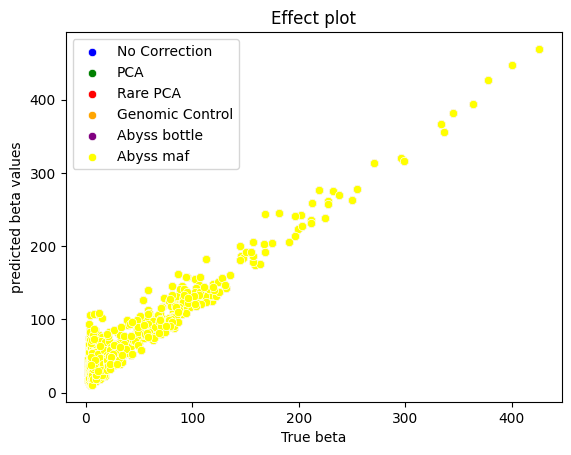

In [24]:
sns.scatterplot(x='true_beta', y='beta_no_corr', data=df_effect, color='blue', label='No Correction')

sns.scatterplot(x='true_beta', y='beta_rare_PCs', data=df_effect, color='green', label='PCA')

sns.scatterplot(x='true_beta', y='beta_common_PCs', data=df_effect, color='red', label='Rare PCA')

sns.scatterplot(x='true_beta', y='beta_GC', data=df_effect, color='orange', label='Genomic Control')

sns.scatterplot(x='true_beta', y='beta_abyss_bottle', data=df_effect, color='purple', label='Abyss bottle')

sns.scatterplot(x='true_beta', y='beta_abyss_maf', data=df_effect, color='yellow', label='Abyss maf')



# Set plot labels and title
plt.xlabel('True beta')
plt.ylabel('predicted beta values')
plt.title(f"Effect plot")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [25]:
snps = []
results = []
different_mafs = ["C", "R", "VR"]
nr_snps_tests = 1
for different_mafs in different_mafs:
    pheno_maf_specific = phenos_mono[[col for col in phenos_mono.columns if col.startswith(different_mafs)]]
    snps_to_test = list(pheno_maf_specific.columns)
    snps_to_test = random.sample(snps_to_test, nr_snps_tests)
    for snp in snps_to_test:
        snps.append(snp)
        y = phenos_mono[[snp]]
        # deep abyss
        bottleneck_nr = 20
        epoch = 100
        patience = 20
        dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
        
        deep_autoencoder, deep_bottleneck_model, deep_history = deep_abyss(complete, bottleneck_nr, epoch, patience, y)
        [deep_abyss_MAF, deep_abyss_pred] = deep_autoencoder(tf.convert_to_tensor(complete, dtype=tf.float32))
        deep_abyss_bottle = deep_bottleneck_model(tf.convert_to_tensor(complete, dtype=tf.float32))
        
        p_deep = (pd.DataFrame(data=deep_abyss_MAF, columns = complete.columns)+1)/2
        deep_abyss_bottleneck = pd.DataFrame(data=deep_abyss_bottle, columns = dim_columns)
        deep_abyss_prediction = pd.DataFrame(data=deep_abyss_pred, columns = ["prediction"])
        
        df_deep_abyss_bottle = manhattan_linear(complete, y, deep_abyss_bottleneck)
        df_deep_abyss_maf = manhattan_linear(complete, y, p_deep)
        #df_deep_abyss_pred = manhattan_linear(complete, y, deep_abyss_prediction)
        ## Test
        df_deep_abyss_pred = manhattan_linear(complete - (p_deep-(1-p_deep)), y[snp] , deep_abyss_bottleneck)
        
        df_deep_abyss_genocorr = manhattan_linear(complete - (p_deep-(1-p_deep)), y[snp] - deep_abyss_prediction['prediction'])
        results.append([df_deep_abyss_bottle, df_deep_abyss_maf, df_deep_abyss_pred, df_deep_abyss_genocorr])

Global phenotype
Covs
Global phenotype
Abyss!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
No Covs!
Global phenotype
Covs
Global phenotype
Abyss!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
No Covs!
Global phenotype
Covs
Global phenotype
Abyss!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
No Covs!


In [26]:
deep_bottle_results = []
deep_maf_results = []
deep_pred_results = []
deep_corr_results = []

for i in range(len(snps)):
    deep_bottle_result = results[i][0]
    deep_bottle_result = deep_bottle_result.loc[deep_bottle_result['snp'] == snps[i].split("_")[0]]
    deep_bottle_results.append(deep_bottle_result)


    deep_maf_result = results[i][1]
    deep_maf_result = deep_maf_result.loc[deep_maf_result['snp'] == snps[i].split("_")[0]]
    deep_maf_results.append(deep_maf_result)

    
    deep_pred_result = results[i][2]
    deep_pred_result = deep_pred_result.loc[deep_pred_result['snp'] == snps[i].split("_")[0]]
    deep_pred_results.append(deep_pred_result)

    
    deep_corr_result = results[i][3]
    deep_corr_result = deep_corr_result.loc[deep_corr_result['snp'] == snps[i].split("_")[0]]
    deep_corr_results.append(deep_corr_result)

    
deep_bottle_results = pd.concat(deep_bottle_results, ignore_index=True)
deep_bottle_results = pd.merge(deep_bottle_results, betas, on='snp')

deep_maf_results = pd.concat(deep_maf_results, ignore_index=True)
deep_maf_results = pd.merge(deep_maf_results, betas, on='snp')

deep_pred_results = pd.concat(deep_pred_results, ignore_index=True)
deep_pred_results = pd.merge(deep_pred_results, betas, on='snp')

deep_corr_results = pd.concat(deep_corr_results, ignore_index=True)
deep_corr_results = pd.merge(deep_corr_results, betas, on='snp')

In [27]:
# Create effect plot
df_effect_deep = pd.DataFrame()
df_effect_deep["beta_deep_abyss_bottle"] = deep_bottle_results['coefs']
df_effect_deep["beta_deep_abyss_maf"] = deep_maf_results['coefs']
df_effect_deep["beta_deep_abyss_pred"] = deep_pred_results['coefs']
df_effect_deep["beta_deep_abyss_genocorr"] = deep_corr_results['coefs']

df_effect_deep['true_beta'] = deep_corr_results['Beta']

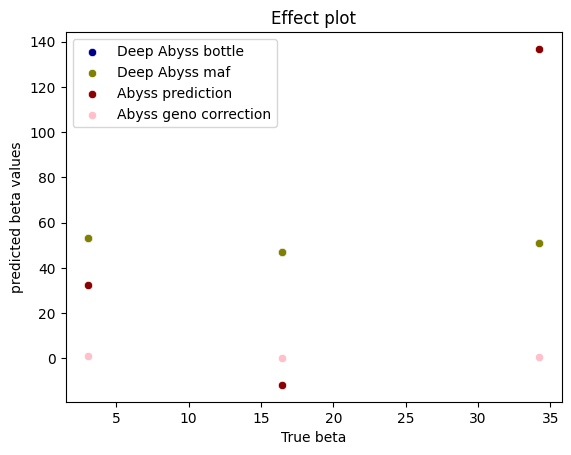

In [28]:
sns.scatterplot(x='true_beta', y='beta_deep_abyss_bottle', data=df_effect_deep, color='darkblue', label='Deep Abyss bottle')

sns.scatterplot(x='true_beta', y='beta_deep_abyss_maf', data=df_effect_deep, color='olive', label='Deep Abyss maf')

sns.scatterplot(x='true_beta', y='beta_deep_abyss_pred', data=df_effect_deep, color='darkred', label='Abyss prediction')

sns.scatterplot(x='true_beta', y='beta_deep_abyss_genocorr', data=df_effect_deep, color='pink', label='Abyss geno correction')



# Set plot labels and title
plt.xlabel('True beta')
plt.ylabel('predicted beta values')
plt.title(f"Effect plot")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()